<a href="https://colab.research.google.com/github/fringewidth/felineflow/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Train FelineFlow**
In this notebook, we will train a diffusion model to generate 256x256 images of cats🐈

## Setup
Let's use Google's TPUs to speed up the training process, and also import other necessary modules.

In [ ]:
!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

In [3]:
# import torch_xla
# import torch_xla.core.xla_model as xm
import matplotlib.pyplot as plt
from google.colab import drive
import torch
import torchvision
import torch.nn as nn
import math

In [6]:
# dev = xm.xla_device()

## 🔃Loading cute cats...
Let's import the dataset. I've used 4096 images of cats from [Microsoft Research's Cats vs. Dogs Dataset.](https://www.microsoft.com/en-us/download/details.aspx?id=54765)
I've cropped the data to a 256x256 resolution.
The processed data is available [here](https://github.com/fringewidth/felineflow/blob/main/cats_processed.zip) as a `.zip`.

In [ ]:
#get dataset
!wget https://github.com/fringewidth/felineflow/raw/main/cats_processed.zip
!mkdir -p dataset/cats
!unzip cats_processed.zip -d dataset/cats

In [8]:
cats = torchvision.datasets.ImageFolder(root='dataset', transform = torchvision.transforms.ToTensor())

In [9]:
#get dataloader
cats_loader = torch.utils.data.DataLoader(cats, batch_size=64, shuffle=True)

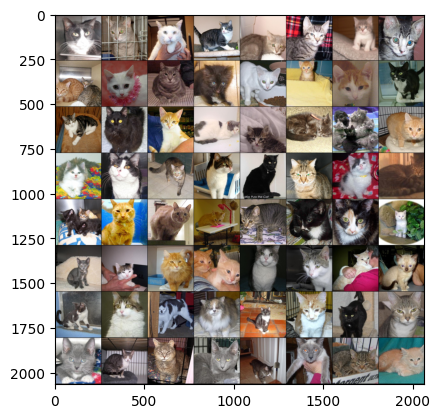

In [10]:
#get sample batch
sample_batch, labels = next(iter(cats_loader))

#make grid image
grid = torchvision.utils.make_grid(sample_batch)

#convert CHW(channels, height, width) to HWC and display
grid = grid.permute(1,2,0)
plt.imshow(grid)

## Forward Diffusion
Let's now implement the forward diffusion process

In [11]:
#function to get a linear noise schedule
def get_noise_schedule(start, end, timesteps):
  beta = torch.linspace(start, end, timesteps)
  alpha = 1 - beta
  alpha_bar = torch.cumprod(alpha, dim=0)
  return beta, alpha, alpha_bar

In [12]:
def get_noised_image(image, alpha_bar, t):
  image_t = image * torch.sqrt(alpha_bar[t]) + torch.sqrt((1-alpha_bar[t]))*torch.randn_like(image)
  return image_t

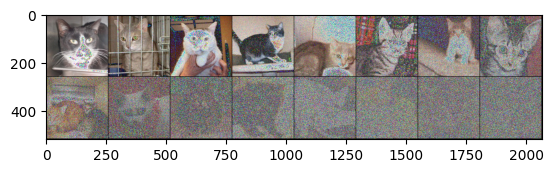

In [131]:
#test forward diffusion
sample_steps=16
beta, alpha, alpha_bar = get_noise_schedule(1e-4, 0.02, sample_steps)
img_arr = torch.empty(sample_steps,3,256,256)
for t in range(sample_steps):
  img_arr[t] = (get_noised_image(sample_batch[t], alpha_bar, t)*255).type(torch.uint8)

noised_grid = torchvision.utils.make_grid(img_arr).permute(1,2,0)
plt.imshow(noised_grid.type(torch.uint8))

## U-Net
Let's now implement the U-Net that predicts the reverse diffusion process. I've designed the U-Net as follows, taking the following into consideration:
- Experimental evidence of better performance from [Prafulla Dhariwal et al.](https://arxiv.org/abs/2105.05233) on increasing the depth of the network while decreasing the width; i.e., large number of convolutional layers with gradual increasing of the number of channels.
- Strategic placement of self-attention modules to capture both resolution and a large amount of features.
- Alternate skip connections to preserve high level semantic information while reducing computational overhead.
- Computationally efficient ReLU activation functions for quick training and inference, while still experimenting with more exotic activations for the attention modules.
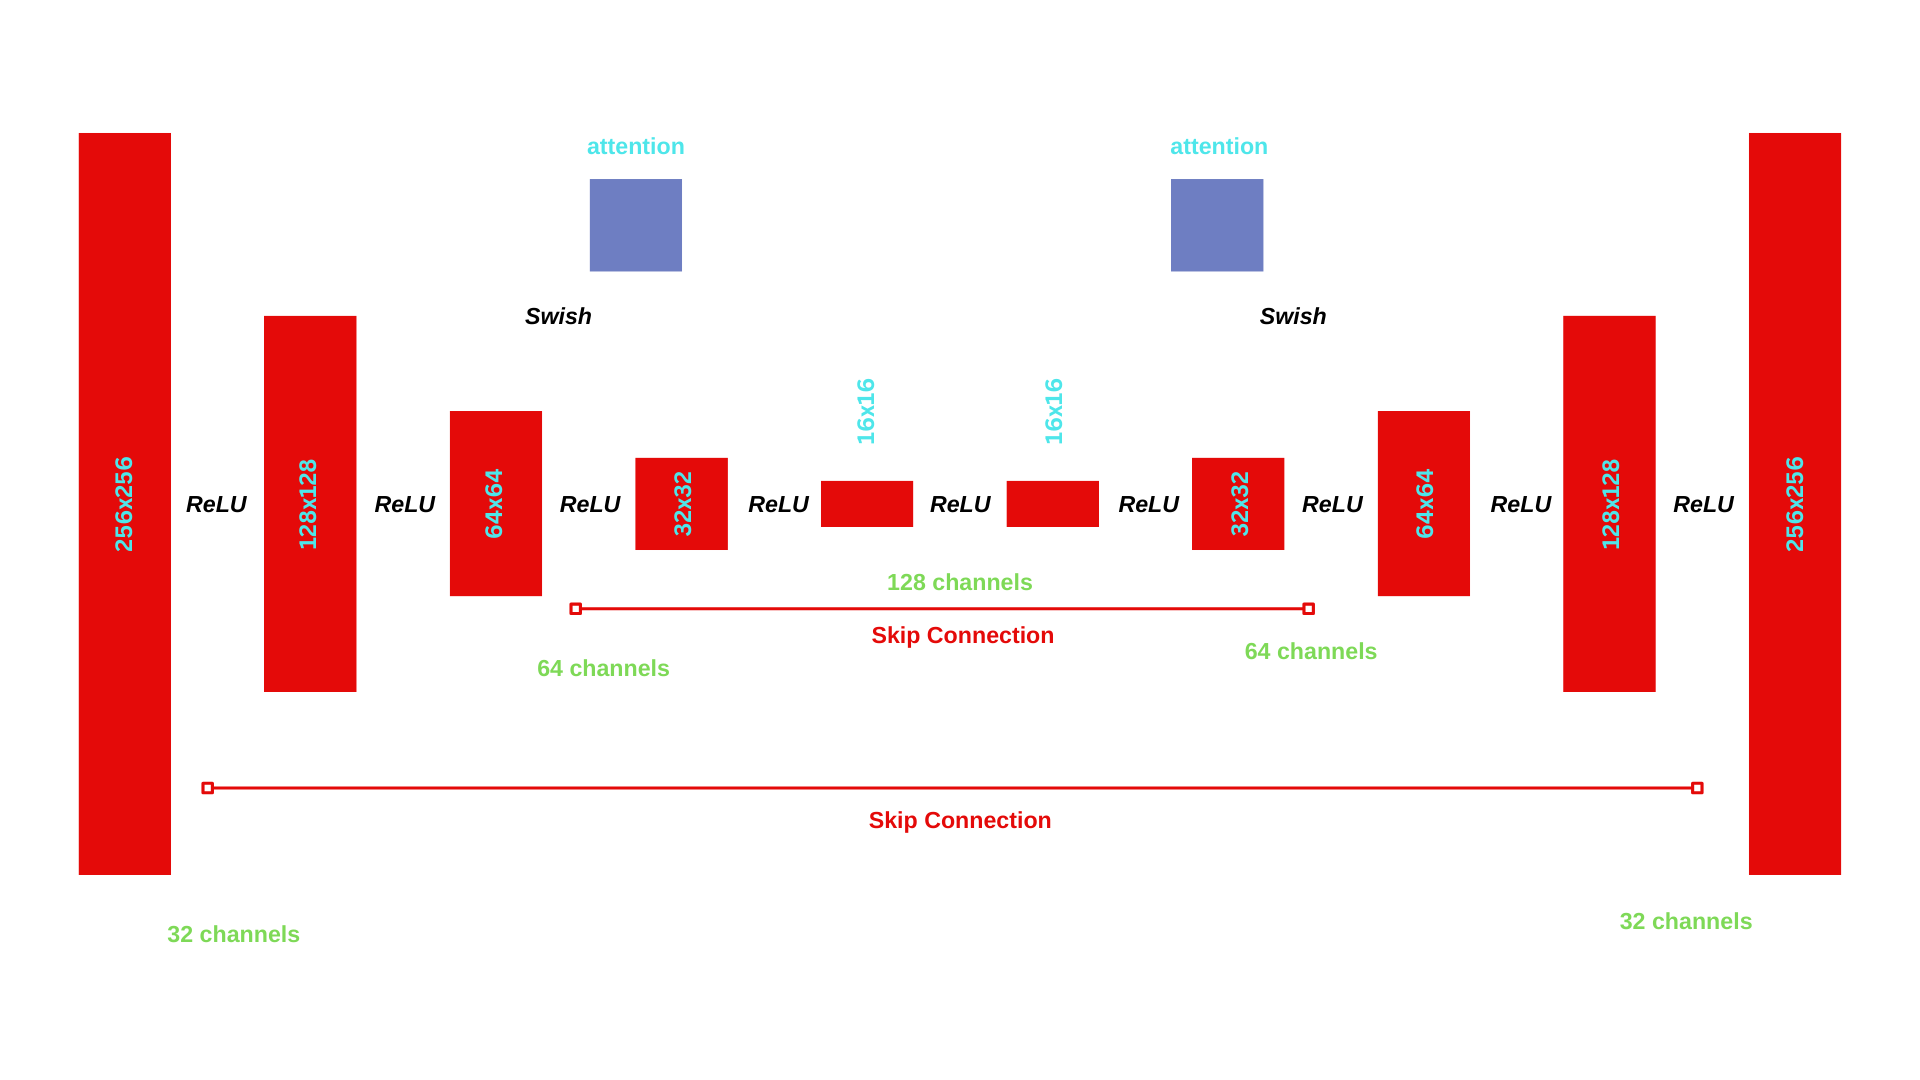

###Define an enumeration for Activation functions

In [14]:
from enum import Enum
class ActivationFunction(Enum):
  RELU = 0
  SWISH = 1

## Define the timestep encoding
We will use the Sinusoidal Embedding first used for the transformer architecture in the famous [Attention is all you need](https://arxiv.org/abs/1706.03762) paper.

In [15]:
def SinusoidalEmbedding(k, dim, n=10000):
  pos = torch.arange(dim//2)
  emb = k * torch.exp(-2*math.log(n)/dim * pos)
  return torch.stack((torch.sin(emb), torch.cos(emb))).permute(1,0).reshape(-1)

### Define the encoder module
The encoder module in our U-Net downsamples the input image by 2 and doubles the number of channels.

The decoder module has two ReLU activating convolutional layers and a max pooling layer. The second convolutional layer doubles the number of channels, while the max pool layer is responsible for halving the resolution.

In [121]:
class Encoder(nn.Module):
  def __init__(self, in_channels, out_channels, activation_function=ActivationFunction.RELU, kernel_size=3, stride=1, padding=1):
    super().__init__()
    self.time_dim = 32
    self.activation = nn.ReLU() if activation_function == ActivationFunction.RELU else nn.SiLU()
    self.pre = nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding),
        self.activation
    )
    self.timeEmb = nn.Sequential(
      nn.Linear(self.time_dim, in_channels),
      nn.ReLU()
    )
    self.post = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        self.activation,
        nn.MaxPool2d(2),
        nn.BatchNorm2d(out_channels)
    )

  def forward(self, x, timestep):
    pre = self.pre(x)
    pre += self.timeEmb(SinusoidalEmbedding(timestep, self.time_dim))[:,None,None].repeat(1,pre.size()[-2], pre.size()[-1])
    post = self.post(pre.unsqueeze(0))
    return post.squeeze()


### Define the decoder module
The decoder module reverses the encoding process, i.e halves the number of channels and doubles the resolution. We employ three layers in the decoder for this purpose. The first two layers perform the transpose convolution operation, where the second layer halves the number of channels. This is followed by a regular convolution operation.

In [112]:
class Decoder(nn.Module):
  def __init__(self, in_channels, out_channels, activation_function=ActivationFunction.RELU, kernel_size=3, stride=1, padding=1):
    super().__init__()
    self.time_dim = 32
    self.activation = nn.ReLU() if activation_function == ActivationFunction.RELU else nn.SiLU()
    self.pre = nn.Sequential(
        nn.ConvTranspose2d(in_channels, in_channels, 4, 2, 1),
        self.activation
    )
    self.timeEmb = nn.Sequential(
      nn.Linear(self.time_dim, in_channels),
      nn.ReLU()
    )
    self.post = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        self.activation
    )

  def forward(self, x, timestep):
    pre = self.pre(x)
    pre += self.timeEmb(SinusoidalEmbedding(timestep, self.time_dim))[:,None,None].repeat(1,pre.size()[-2], pre.size()[-1])
    post = self.post(pre)
    return post